In [7]:
from IPython.core.display import HTML

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.decomposition import TruncatedSVD

import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix

import graphlab
from copy import copy, deepcopy

In [8]:
HTML("""<iframe
          width="600"
          height="400"
          seamless
          frameBorder="0"
          scrolling="no"
          src="http://localhost:8088/superset/explore/table/3/?form_data=%7B%22datasource%22%3A%223__table%22%2C%22viz_type%22%3A%22table%22%2C%22granularity_sqla%22%3Anull%2C%22time_grain_sqla%22%3Anull%2C%22since%22%3A%227+days+ago%22%2C%22until%22%3A%22now%22%2C%22groupby%22%3A%5B%22genre%22%5D%2C%22metrics%22%3A%5B%22count%22%5D%2C%22include_time%22%3Afalse%2C%22all_columns%22%3A%5B%5D%2C%22order_by_cols%22%3A%5B%5D%2C%22table_timestamp_format%22%3A%22smart_date%22%2C%22row_limit%22%3Anull%2C%22page_length%22%3A0%2C%22include_search%22%3Afalse%2C%22table_filter%22%3Afalse%2C%22where%22%3A%22%22%2C%22having%22%3A%22%22%2C%22filters%22%3A%5B%5D%7D&standalone=true&height=400"
        >
        </iframe>""")

---
# Рекомендательные системы
---

В этой лабораторной работе будет рассмотрена задача предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Будем работать с датасетом MovieLens + IMDb/Rotten Tomatoes. Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов MovieLens. Пользовательские оценки для фильмов принимают ~~целые~~ значения в интервале от 1 до 5, они записаны в файле user_ratedmovies.dat (а так же в user_ratedmovies-timestamps.dat, где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

На основании этих данных необходимо построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

# Dataset:

MovieLens + IMDb/Rotten Tomatoes

---

### Description

---

This dataset is an extension of MovieLens10M dataset, published by GroupLeans 
research group.

http://www.grouplens.org 

It links the movies of MovieLens dataset with their corresponding web pages at 
Internet Movie Database (IMDb) and Rotten Tomatoes movie review systems.

http://www.imdb.com 

http://www.rottentomatoes.com 

From the original dataset, only those users with both rating and tagging information 
have been mantained.

---

### Data statistics

---
<table>
<tr style="border-bottom: 2pt solid black;"><th>count</th><th>name</th></tr>
<tr><td>2113</td><td>users</td> </tr>
<tr style="border-bottom: 2pt solid black;"><td>10197</td><td>movies</td></tr>

<tr><td>20</td><td>movie genres</td></tr>
<tr><td>20809</td><td>movie genre assignments</td> </tr>
<tr style="border-bottom: 2pt solid black;"><td></td><td>avg. 2.040 genres per movie</td></tr>

<tr><td>4060</td><td>directors</td></tr>
<tr><td>95321</td><td>actors</td></tr>
<tr><td></td><td>avg. 22.778 actors per movie</td></tr>
<tr style="border-bottom: 2pt solid black;"><td>72</td><td>countries</td></tr>

<tr><td>10197</td><td>country assignments</td></tr>
<tr><td></td><td>avg. 1.000 countries per movie</td></tr>
<tr><td>47899</td><td>location assignments</td></tr>
<tr style="border-bottom: 2pt solid black;"><td></td><td>avg. 5.350 locations per movie</td></tr>

<tr><td>13222</td><td>tags</td></tr>
<tr><td>47957</td><td>tag assignments (tas), i.e. tuples [user, tag, movie]</td></tr>
<tr><td></td><td>avg. 22.696 tas per user</td></tr>
<tr style="border-bottom: 2pt solid black;"><td></td><td>avg. 8.117 tas per movie</td></tr>

<tr><td>855598</td><td>ratings</td></tr>
<tr><td></td><td>avg. 404.921 ratings per user</td></tr>
<tr style="border-bottom: 2pt solid black;"><td></td><td>avg. 84.637 ratings per movie</td></tr>

</table>

---
# Оценивание качества рекомендаций:
---

Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов этого пользователя $R^u_{test}$ рассмотрим три рейтинга, поставленные последними по времени. Остальные известные рейтинги будут составлять обучающую выборку $R^u_{train}$. Тогда все известные рейтинги можно представить как $R^u = R^u_{train} \cup R^u_{test}$. Отсутствующие оценки обозначим за $R^u_{unknown}$. Объединив эти наборы для всех пользователей, получим наборы $R_{train}$, $R_{test}$ и $R_{unknown}$.

Для измерения качества рекомендаций в этой лабораторной работе будем использовать две метрики RMSE и MAP, описанные ниже.

---
### RMSE
---
Метрика RMSE вычисляется следующим образом:

\begin{array}
-RMSE & =  &\sqrt{\frac{1}{|R_{test}|}\sum_{(u, i) \in R_{test}} (r_{ui} - \widehat{r}_{ui})^2}
\end{array}

где $r_{ui}$ - наблюдаемая (правильная) оценка, а  $\widehat{r}_{ui}$ - оценка, предсказанная моделью.

Метрика RMSE предназначена для оценки точности предсказания, ее удобно оптимизировать напрямую. Однако, нужно учесть, что RMSE не лучший кандидат для оценки качества рекомендаций:

* Во-первых, RMSE оценивает точность предсказания рейтингов, что в задачах рекомендаций, как правило, менее важно, нежели верное ранжирование объектов (безотносительно абсолютных значений рейтингов). На практике часто бывает, что алгоритмы с худшим RMSE в продакшене работают лучше, нежели алгоритмы с меньшим значением RMSE. Например, при использовании моделей рекомендаций на основе матричных разложений, заполнение отсутствующих оценок нулями даёт худшее значение по RMSE, но при этом часто сами рекомендации становятся лучше.
* Во-вторых, RMSE одинаково штрафует точность предсказания оценок фильмам с большим значением предпочтения (которые попадут в блок рекомендаций) и фильмам с малым значением предпочтения (длинный хвост из нерелевантных фильмов).

---
### MAP
---

Для оценки качества рекомендаций также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и $R^u_{unknown}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Обозначим позиции объектов в этом списке за $k^u_{i}$.

Назовем релевантными те фильмы, которые входят в $R^u_{test}$ и имеют оценку $\ge 3$. Обозначим их за $Rel^u$. Тогда можно считать следующую метрику качества рекомендаций для одного пользователя:

\begin{array}
-AP^u = \frac{1}{|Rel^u|} \sum\limits_{(u, i) \in Rel^u} \frac{1}{k_i^u}.
\end{array}

Усреднив значение этой метрики по всем пользователями, мы получим окончательное значение метрики MAP. Пользователей без релевантных фильмов в тестовой выборке можно не учитывать.

---
### Другие способы оцениваний рекомендаций
---

На практике, как правило, качество рекомендательных систем оценивается в онлайне с помощью A/B-тестирования.

In [3]:
def rmse_metric(data):
    return np.sqrt(np.mean([(row['rating'] - row['prediction']) ** 2 
                            for _, row in data.iterrows()]))

def map_metric(data):
    def ap_metric(user_id, movie_ratings):
        movie_indexs = list(movie_ratings.sort_values(by='prediction', ascending=False).index)
        
        value, count_rel = 0., 0
        for movie_id, row in movie_ratings.iterrows():
            if row['rating'] >= 3:
                k = movie_indexs.index(movie_id) + 1
                value += 1. / k
                count_rel += 1
        return value / count_rel if count_rel > 0 else 0.
    
    value, count_rel = 0., 0
    for user_id, movie_ratings in data.reset_index().groupby('userID'):
        t = ap_metric(user_id, movie_ratings.set_index('movieID'))
        
        if t > 0.:
            value += t
            count_rel += 1
    
    return value / count_rel if count_rel > 0 else 0

# Коллаборативная фильтрация

Загрузите данные и создайте матрицу пользователи-фильмы, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [4]:
data = pd.read_table('data/user_ratedmovies-timestamps.dat', encoding='cp1251', index_col=['userID', 'movieID'])
data.head(5)

rating      timestamp
userID movieID                       
75     3           1.0  1162160236000
       32          4.5  1162160624000
       110         4.0  1162161008000
       160         2.0  1162160212000
       163         4.0  1162160970000

In [5]:
in_train = np.array([True] * data.shape[0])

prev_user_id = None
for i, (index, row) in enumerate(data.iterrows()):
    user_id, movie_id = index
    if prev_user_id != user_id:
        prev_user_id = user_id
        border_timestamp = data.ix[user_id].sort_values('timestamp').iloc[-3]['timestamp']
    
    timestamp = row['timestamp']
    if timestamp >= border_timestamp:
        in_train[i] = False

train = data[in_train]
test = data[np.logical_not(in_train)]

R = pd.pivot_table(data.reset_index(), 
                   columns='movieID', 
                   index='userID', 
                   values='rating', 
                   aggfunc=np.mean, 
                   fill_value=0.)

unknown = R.stack().drop(data.index)

In [6]:
if 1 == 0:
    train.to_csv('data/solution/solution.train.csv')
    test.to_csv('data/solution/solution.test.csv')
    unknown.to_csv('data/solution/solution.unknown.csv')

In [7]:
if 1 == 0:
    train = pd.read_csv('data/solution/solution.train.csv', index_col=['userID', 'movieID'])
    test = pd.read_csv('data/solution/solution.test.csv', index_col=['userID', 'movieID'])
    unknown = pd.read_csv('data/solution/solution.unknown.csv', header=None)
    unknown.columns = ['userID', 'movieID', 'rating']
    unknown = unknown.set_index(['userID', 'movieID'])

# 1. Most popular method

Постройте рекоммендации на основе __most popular__ метода, при котором пользователям рекомендуются объекты в порядке убываниях их популярности (например, среднего рейтинга). Оцените качество рекомендаций с использованием метрики MAP.

In [8]:
movie_ratings = train.reset_index().groupby('movieID').agg({'rating': np.mean})
movie_ratings.columns = ['prediction']
prediction = pd.concat([test, unknown]).join(movie_ratings).fillna(0.)
prediction.head()

0  rating     timestamp  prediction
userID movieID                                       
75     2571     0.0     4.5  1.162161e+12    4.174834
       5952     0.0     3.5  1.162161e+12    4.032301
       7153     0.0     3.5  1.162161e+12    4.095090
78     8400     0.0     4.5  1.177224e+12    3.656250
       44694    0.0     2.0  1.179550e+12    3.859447

In [9]:
print('MAP: %f' % map_metric(prediction))
print('RMSE: %f' % rmse_metric(prediction))

MAP: 0.001123
RMSE: 3.262988


# 2. Item-based method

Теперь рассмотрим __memory-based__ методы рекоммендаций. Подход, лежащий в их основе, использует данные о рейтингах для вычисления сходства между пользователями (__user-based__) или объектами (__item-based__), на основе этих данных делаются предсказания рейтингов и, в дальнейшем, строятся рекоммендации. Эти методы просты в реализации и эффективны на ранних стадиях разработки рекомендательных систем.

Постройте рекоммендации на основе item-based подхода, реализованном в библиотеке Graphlab Create. Оцените качество рекомендаций, в зависимости от выбранной функции похожести __jaccard/cosine/pearson__ по каждой из описанных выше метрик (RMSE, MAP).

### Jacard

In [4]:
model = graphlab.recommender.item_similarity_recommender.create(graphlab.SFrame(data=train.reset_index()),
                                                                user_id='userID',
                                                                item_id='movieID',
                                                                target='rating',
                                                                similarity_type='jaccard')

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 849256 observations with 2113 users and 10084 items.

Data prepared in: 0.98912s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 43.701ms                       | 47.25      |

| 70.773ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 244.414ms                           | 0                | 0               |

| 1.25s                               | 21.25            | 2150            |

| 2.25s                               | 42.25            | 4275            |

| 3.24s                               | 64.75            | 6549            |

| 4.25s                               | 89.25            | 9017            |

| 5.77s                               | 100              | 10084           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 6.92828s

In [5]:
values = pd.concat([test, unknown])
values['prediction'] = model.predict(graphlab.SFrame(data=values.reset_index()))

values.head()

rating     timestamp  prediction
userID movieID                                  
75     2571        4.5  1.162161e+12    0.170676
       5952        3.5  1.162161e+12    0.150593
       7153        3.5  1.162161e+12    0.147598
78     8400        4.5  1.177224e+12    0.000350
       44694       2.0  1.179550e+12    0.000732

In [6]:
print('MAP: %f' % map_metric(values))
print('RMSE: %f' % rmse_metric(values))

MAP: 0.019197
RMSE: 0.066048


### Cosine

In [4]:
model = graphlab.recommender.item_similarity_recommender.create(graphlab.SFrame(data=train[['rating']].reset_index()),
                                                                user_id='userID',
                                                                item_id='movieID',
                                                                target='rating',
                                                                similarity_type='cosine')

Recsys training: model = item_similarity

Preparing data set.

Data has 849256 observations with 2113 users and 10084 items.

Data prepared in: 1.03812s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 31.872ms                       | 47.25      |

| 59.902ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 231.241ms                           | 0                | 0               |

| 1.26s                               | 16               | 1637            |

| 2.23s                               | 30.75            | 3119            |

| 3.23s                               | 42.25            | 4263            |

| 4.23s                               | 58.75            | 5927            |

| 5.23s                               | 79               | 7979            |

| 6.23s                               | 99.25            | 10033           |

| 7.72s                               | 100              | 10084           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 8.82776s

In [5]:
values = pd.concat([test, unknown])
values['prediction'] = model.predict(graphlab.SFrame(data=values.reset_index()))

values.head()

rating     timestamp  prediction
userID movieID                                  
75     2571        4.5  1.162161e+12    1.218895
       5952        3.5  1.162161e+12    1.133859
       7153        3.5  1.162161e+12    0.951866
78     8400        4.5  1.177224e+12    0.002233
       44694       2.0  1.179550e+12    0.005015

In [8]:
print('MAP: %f' % map_metric(values))
print('RMSE: %f' % rmse_metric(values))

MAP: 0.021555
RMSE: 0.083389


### Pearson

In [4]:
model = graphlab.recommender.item_similarity_recommender.create(graphlab.SFrame(data=train[['rating']].reset_index()),
                                                                user_id='userID',
                                                                item_id='movieID',
                                                                target='rating',
                                                                similarity_type='pearson')

Recsys training: model = item_similarity

Preparing data set.

Data has 849256 observations with 2113 users and 10084 items.

Data prepared in: 1.18255s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 106.62ms                       | 47.25      |

| 146.322ms                      | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 409.859ms                           | 0                | 0               |

| 1.42s                               | 8                | 826             |

| 2.41s                               | 16.25            | 1642            |

| 3.41s                               | 24.75            | 2501            |

| 4.41s                               | 34.75            | 3527            |

| 5.41s                               | 39.5             | 3995            |

| 6.41s                               | 48.5             | 4903            |

| 7.41s                               | 56.5             | 5716            |

| 8.42s                               | 63               | 6358            |

| 9.41s                               | 67               | 6775            |

| 10.43s                              | 72.25            | 7292            |

| 11.42s                              | 77.25            | 7802            |

| 12.48s                              | 85.5             | 8643            |

| 13.42s                              | 93               | 9389            |

| 15.54s                              | 100              | 10084           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 16.6363s

In [5]:
values = pd.concat([test, unknown])
values['prediction'] = model.predict(graphlab.SFrame(data=values.reset_index()))

values.head()

rating     timestamp  prediction
userID movieID                                  
75     2571        4.5  1.162161e+12    4.179417
       5952        3.5  1.162161e+12    4.024876
       7153        3.5  1.162161e+12    4.088363
78     8400        4.5  1.177224e+12    3.658329
       44694       2.0  1.179550e+12    3.859334

In [6]:
print('MAP: %f' % map_metric(values))
print('RMSE: %f' % rmse_metric(values))

MAP: 0.001124
RMSE: 3.263030


# Разреженный SVD

__Задание:__ Разложите матрицу рейтингов с помощью разреженного SVD и, восстановив ее, получите предсказания рейтингов для всех пар пользователь-объект (этот метод, при котором неизвестные рейтинги заполняются нулями, а затем восстанавливаются с помощью SVD, называется PureSVD). Рассмотрите как минимум 10 различных значений ранга разложения. Оцените качество рекомендаций, используя описанные выше метрики. Для обеих метрик постройте графики зависимости качества алгоритма от выбранного ранга разложения. Как значение ранга влияет на метрики? Не забывайте делать аргументированные выводы на основании полученных результатов.

In [ ]:
def run_svd(n_components):
    global R
    model = TruncatedSVD(n_components=10)

    model.fit(R)
    new_R = pd.DataFrame(data=np.dot(model.transform(R), model.components_),
                         index=R.index,
                         columns=R.columns)
    new_R = new_R.stack()
    map_m = map_metric(new_R)
    rmse_m = rmse_metric(new_R)
    print('I: %i\tMAP: %f\tRMSE: %f' % (i, map_m, rmse_m))
    return (n_components, map_m, rmse_m)

In [ ]:
xs, ys, zs = [], [], []

for i in range(5, 101, 5):
    x, y, z = run_svd(i)
    xs.append(x)
    ys.append(y)
    zs.append(z)

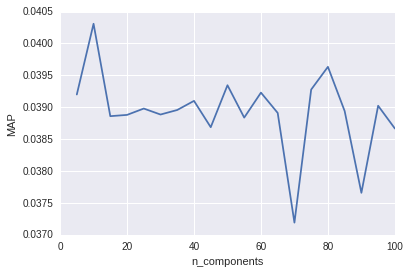

In [8]:
plt.plot(xs, ys, xs, zs)
plt.xlabel('n_components')
plt.ylabel('MAP')

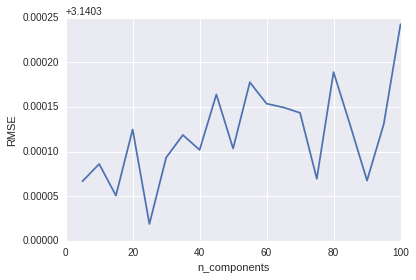

In [11]:
plt.plot(xs, zs)
plt.xlabel('n_components')
plt.ylabel('RMSE')